<a href="https://colab.research.google.com/github/erkoiv/IDS2021-ProjectC8-PetPopularity/blob/main/structuredClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from os import path
from math import sqrt

from tensorflow.keras import layers
from keras.utils import np_utils


In [ ]:
try:
  df = pd.read_csv('/content/drive/MyDrive/Yolov5/IDS2021-ProjectC8-PetPopularity/datasets/train.csv')
except:
  df = pd.read_csv(input("Show me to the data (path)"))

for i in range(df.shape[0]):
  df['Pawpularity'][i] = round(df['Pawpularity'][i]/10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
def sampling_n(group, n=150):
  if len(group) < n:
    return group
  else:
    return group.sample(n, replace=True)

In [ ]:
dflist = df.groupby('Pawpularity')
max = 0
frames=[]
for key, item in dflist:
  if len(dflist.get_group(key)) > max:
    max = len(dflist.get_group(key))

balanced = df.groupby('Pawpularity').apply(sampling_n).reset_index(drop=True)

bal = balanced.groupby('Pawpularity')
for key, item in bal:
  frames.append(bal.get_group(key))

df = pd.concat(frames)


In [ ]:
labels = df.Pawpularity
labels = np_utils.to_categorical(labels)
print(labels)
df["SubjectFocus"] = df["Subject Focus"]
df = df.drop(columns=['Pawpularity', 'Id', 'Subject Focus'])
print(df.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(9912, 12)


In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7929 training examples
991 validation examples
992 test examples


In [ ]:
def df_to_dataset(dataframe, labels, shuffle=True, batch_size=32):
  dataframe = df.copy()
  dataframe = {key: value[:,tf.newaxis] for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [ ]:
batch_size = 256
train_ds = df_to_dataset(train, labels, batch_size=batch_size)
val_ds = df_to_dataset(val, labels, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, labels, shuffle=False, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in df.columns:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(256, activation="relu")(all_features)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(11, activation='sigmoid')(x)

model = tf.keras.Model(inputs=all_inputs, outputs=output)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy", "mse"])

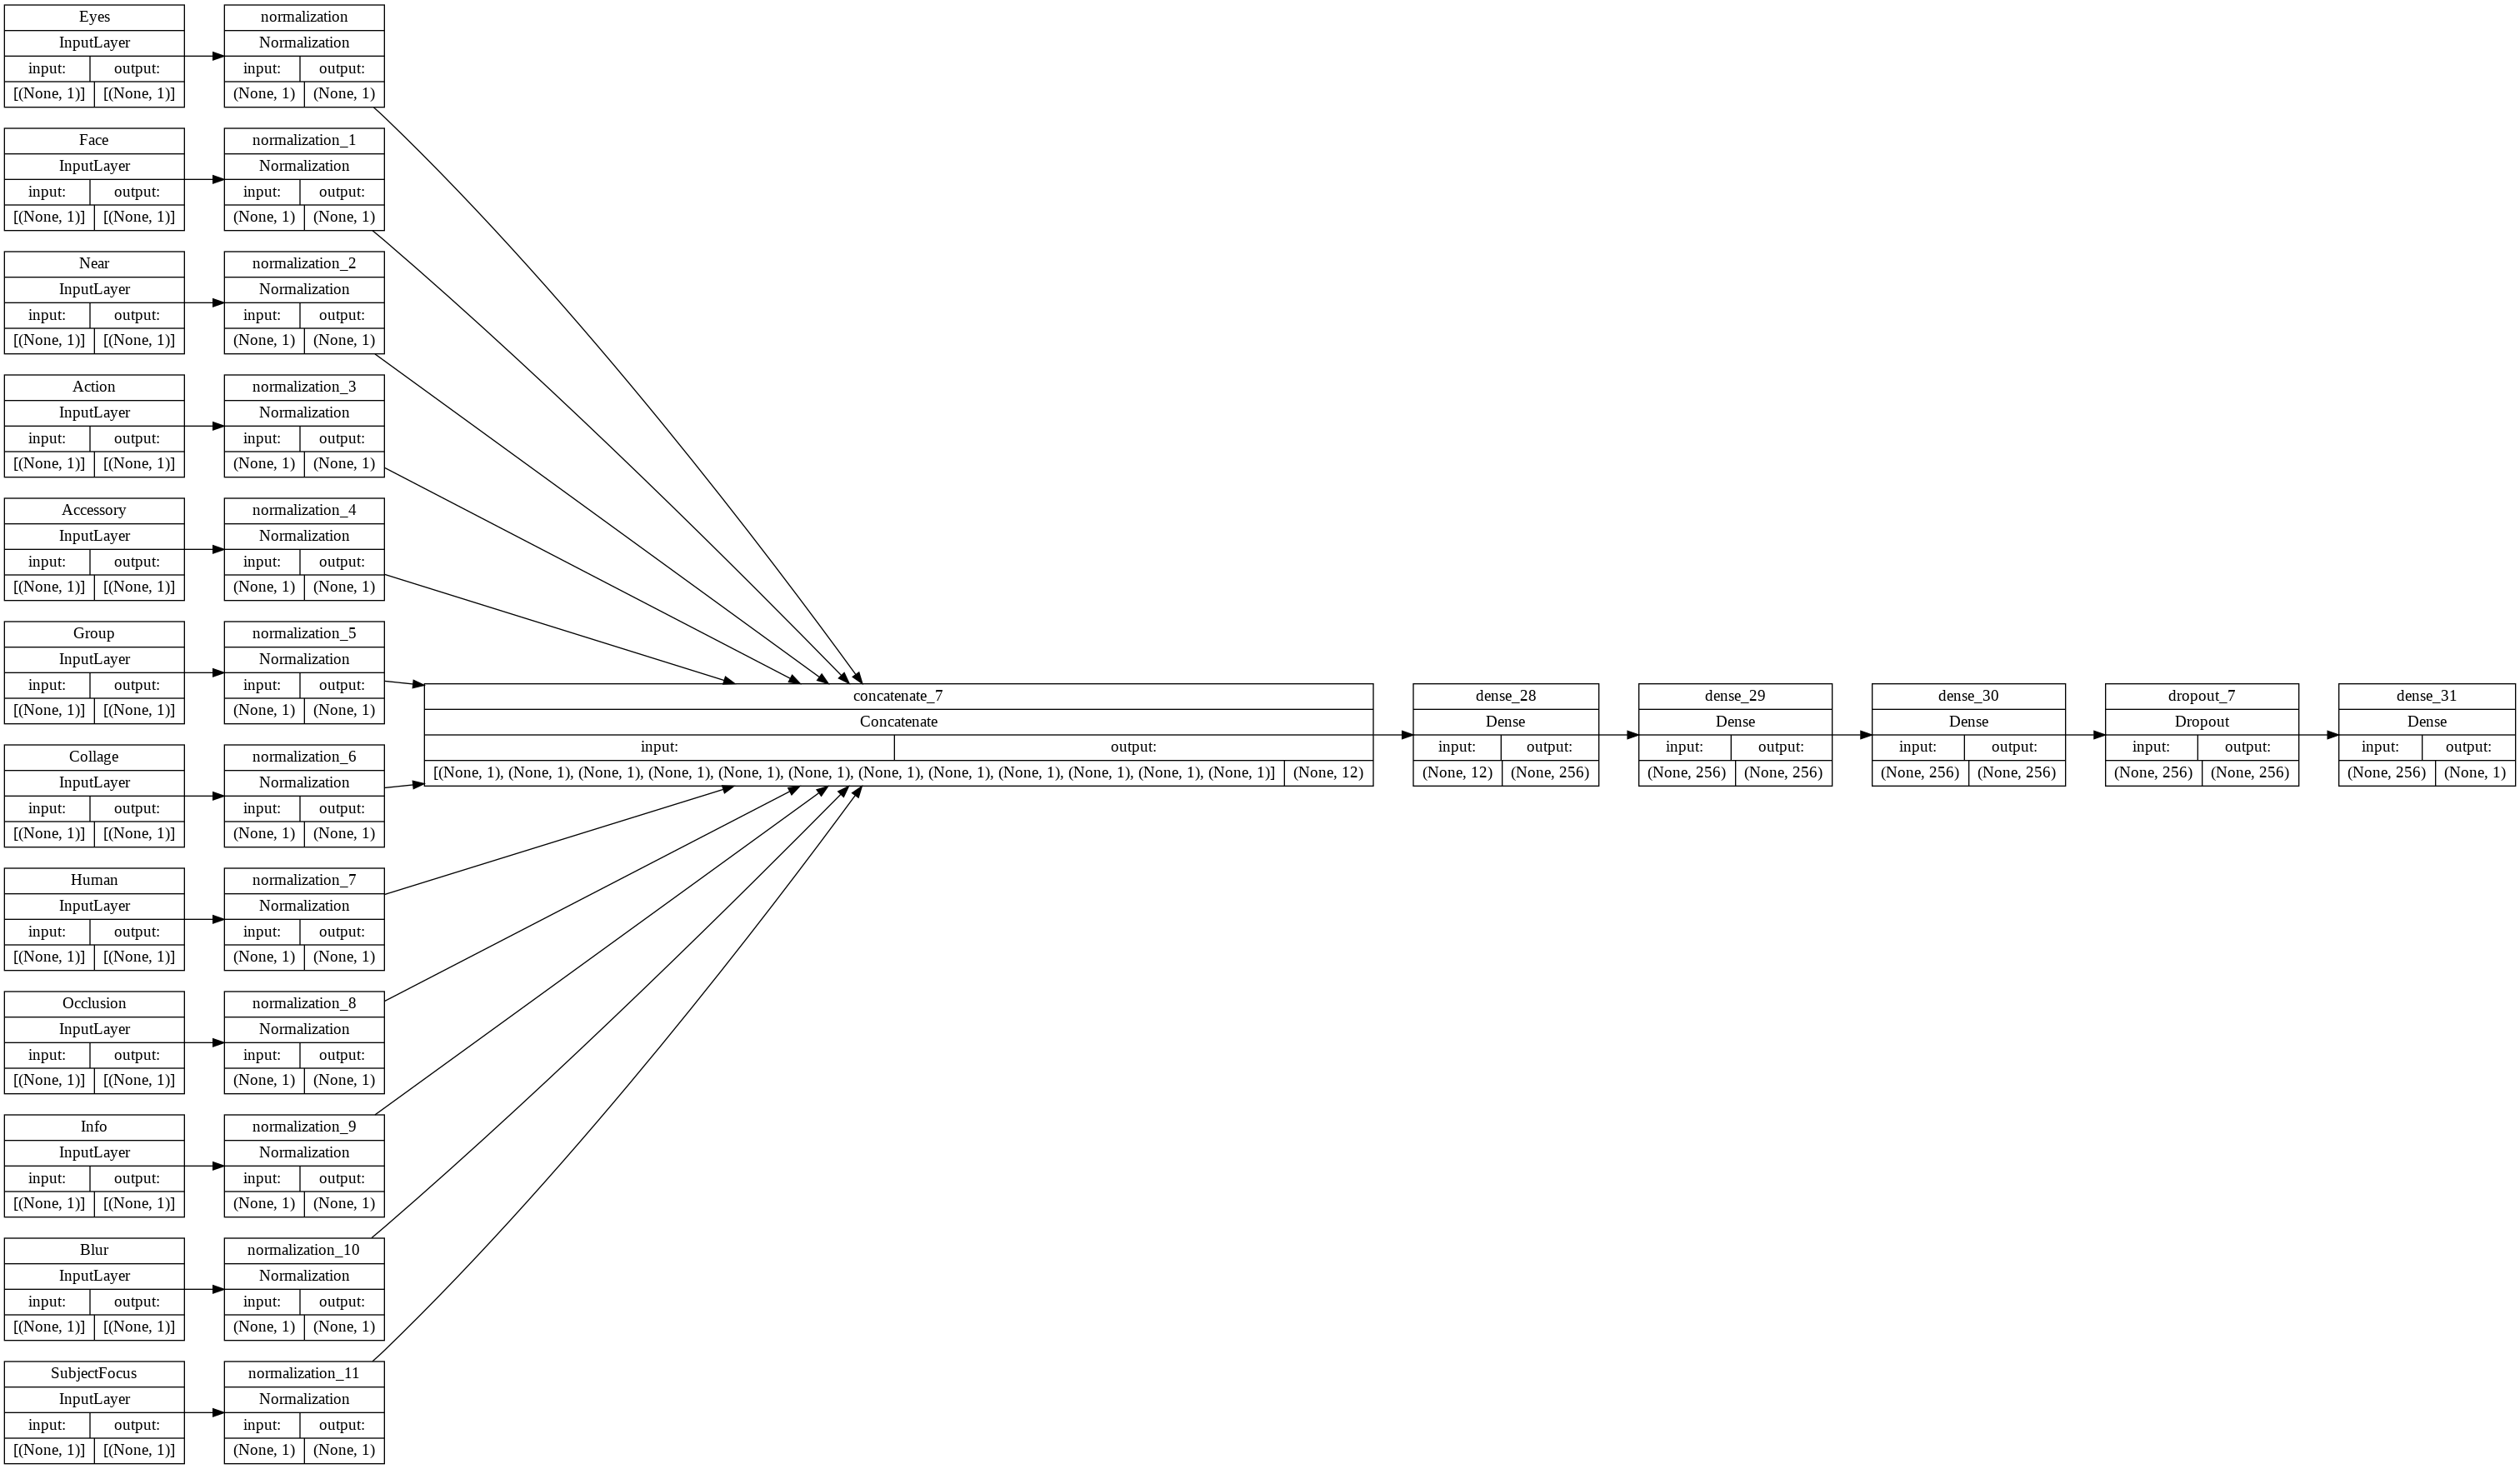

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
epochs = 100
ages = 2
histories = []

filepath= '/content/drive/MyDrive/Yolov5/IDS2021-ProjectC8-PetPopularity/tfLatest'
if not path.exists(filepath):
  filepath = input("Where should I save the model? ")

for i in range(1, ages+1):
  print("Age {}".format(i))
  histories.append(model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1))
  model.save(filepath)
#this should save a model every 10min to allow for semi-autonomous training on colab

Age 1
Epoch 1/100
39/39 [==============================] - 2s 27ms/step - loss: 0.3083 - accuracy: 0.2132 - mse: 0.0897 - val_loss: 0.2643 - val_accuracy: 0.2652 - val_mse: 0.0754
Epoch 2/100
39/39 [==============================] - 1s 21ms/step - loss: 0.2699 - accuracy: 0.2466 - mse: 0.0767 - val_loss: 0.2642 - val_accuracy: 0.2646 - val_mse: 0.0755
Epoch 3/100
39/39 [==============================] - 1s 22ms/step - loss: 0.2684 - accuracy: 0.2512 - mse: 0.0764 - val_loss: 0.2645 - val_accuracy: 0.2699 - val_mse: 0.0755
Epoch 4/100
39/39 [==============================] - 1s 23ms/step - loss: 0.2674 - accuracy: 0.2598 - mse: 0.0761 - val_loss: 0.2645 - val_accuracy: 0.2785 - val_mse: 0.0753
Epoch 5/100
39/39 [==============================] - 1s 23ms/step - loss: 0.2670 - accuracy: 0.2634 - mse: 0.0759 - val_loss: 0.2633 - val_accuracy: 0.2745 - val_mse: 0.0752
Epoch 6/100
39/39 [==============================] - 1s 22ms/step - loss: 0.2665 - accuracy: 0.2615 - mse: 0.0758 - val_loss

KeyboardInterrupt: ignored

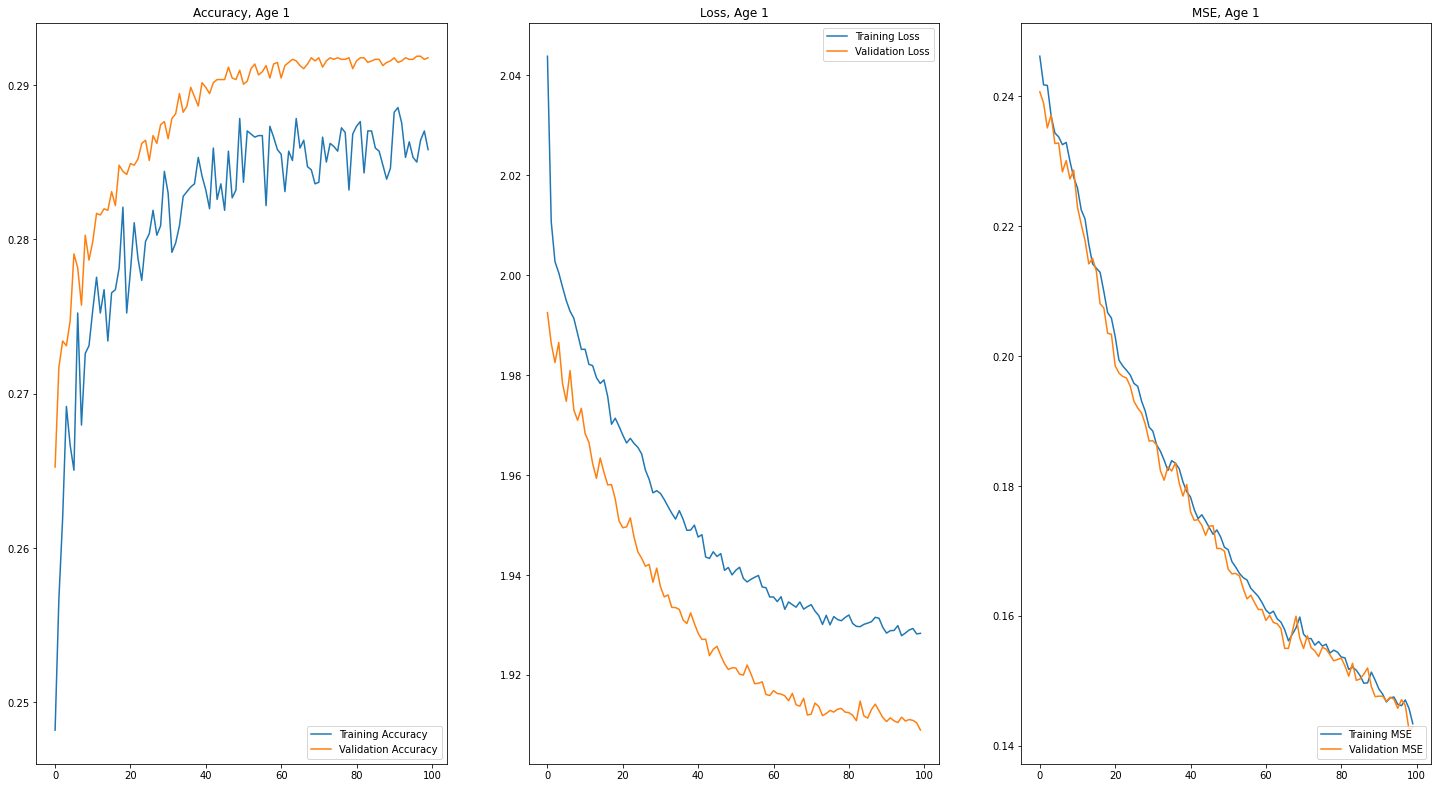

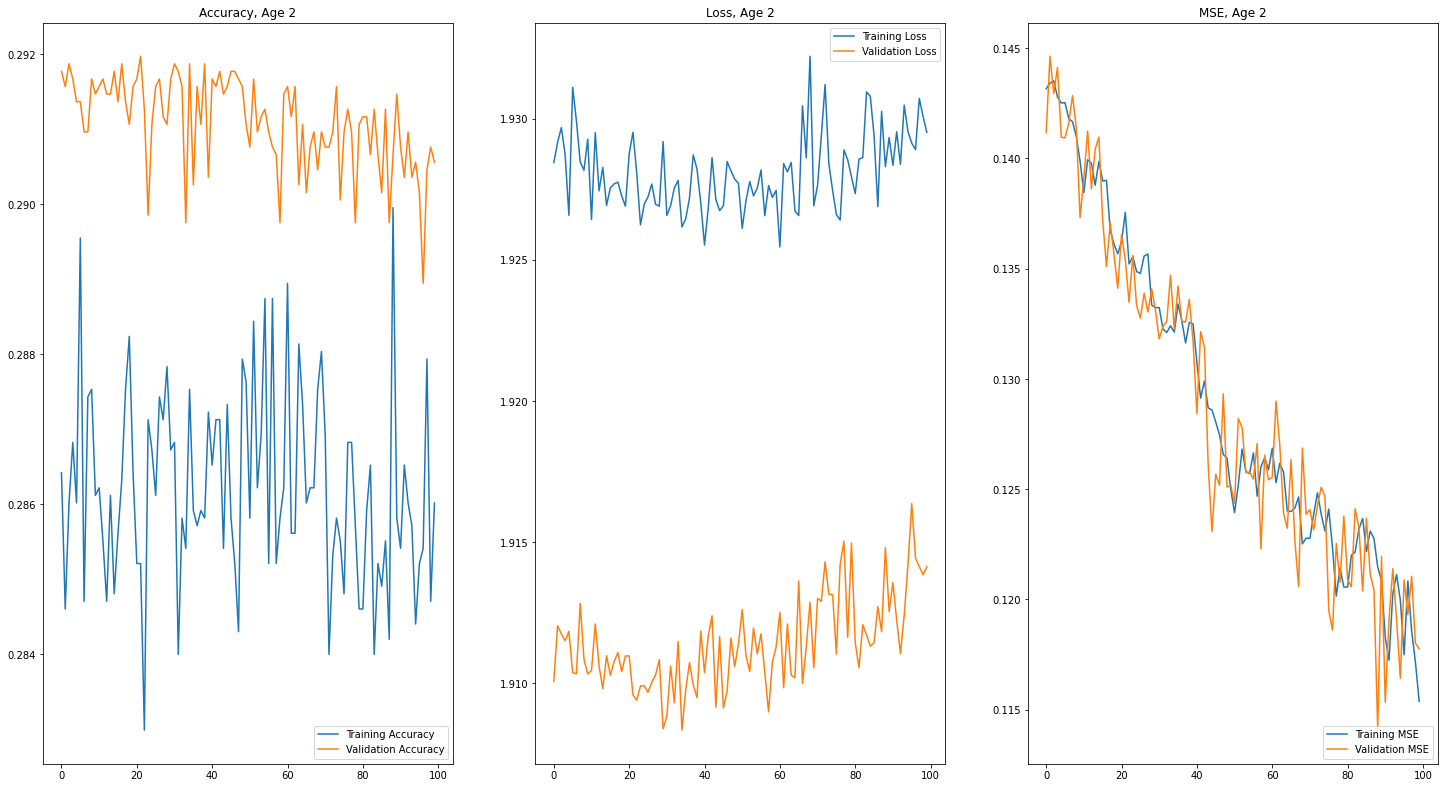

In [ ]:
pltcounter = 1
for index, history in enumerate(histories, start=1):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  mse = history.history['mse']
  val_mse = history.history['val_mse']

  epochs_range = range(epochs)

  plt.figure(figsize=(25, 30))
  plt.subplot(ages, 3, pltcounter)
  title = 'Accuracy, Age {}'.format(index)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title(title)
  pltcounter += 1

  plt.subplot(ages, 3, pltcounter)
  title = 'Loss, Age {}'.format(index)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title(title)
  pltcounter += 1

  plt.subplot(ages, 3, pltcounter)
  title = 'MSE, Age {}'.format(index)
  plt.plot(epochs_range, mse, label='Training MSE')
  plt.plot(epochs_range, val_mse, label='Validation MSE')
  plt.legend(loc='lower right')
  plt.title(title)
  pltcounter += 1
plt.show()

In [ ]:
loss, accuracy, mse= model.evaluate(test_ds)
print("Accuracy ", accuracy, ", Loss ", loss, ", MSE ", mse, ", RMSE ", sqrt(mse))

39/39 [==============================] - 0s 6ms/step - loss: 0.2576 - accuracy: 0.2884 - mse: 0.0741
Accuracy  0.28843826055526733 , Loss  0.2576480805873871 , MSE  0.0741003155708313 , RMSE  0.2722137314149147


In [ ]:
try:
  df = pd.read_csv('/content/drive/MyDrive/Yolov5/IDS2021-ProjectC8-PetPopularity/datasets/test.csv')
except:
  filepath = input("Show me to the prediction data (path)")
  df = pd.read_csv(filepath)

predictionIds = pd.DataFrame(df.Id.values, columns=["Id"])

df = df.drop("Id", axis=1)
df["SubjectFocus"] = df["Subject Focus"]
df = df.drop("Subject Focus", axis=1) 

sampleset = df.to_dict('records')
predictions = []
for sample in sampleset:
  input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
  prediction = model.predict(input_dict)
  max = 0
  popularity = 0
  add = 0
  for label, probability in enumerate(prediction[0]):
    if probability > max:
      max = probability
      if probability > 0.5:
        add = round((probability-0.5)*10, 2)
      else:
        add = round((probability)*-10, 2)
      
      popularity = (label*10)+add

  predictions.append(popularity)

predictions = pd.DataFrame(predictions, columns=["Pawpularity"])
submittable = predictionIds.join(predictions)

submittable.to_csv("/content/drive/MyDrive/Yolov5/IDS2021-ProjectC8-PetPopularity/submission.csv", index=False)

#predictions.head(5)